# Bayesian inference in non-linear dynamic models

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.integrate import solve_ivp
import scipy.optimize

red, blue, green = sns.color_palette('Set1', 3)

The analysis follows an example from the [PyMC docs](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html#pymc-model-specification-for-gradient-free-bayesian-inference).

## Predator-prey data

Here's data from a real predator-prey system -- the hare and lynx system, see for example:
> Krebs, Boonstra, Boutin, Sinclair (2006). [What drives the 10-year cycle of snowshoe hares?](https://www.bio.fsu.edu/~james/krebs.pdf) _BioScience_

> Deng (2018). [An Inverse Problem: Trappers Drove Hares to Eat Lynx.](https://doi.org/10.1007/s10441-018-9333-z) _Acta Biotheoretica_

In [5]:
data = pd.DataFrame(dict(
    year = np.arange(1900., 1921., 1),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))

XY = data[['hare', 'lynx']].values.T
data.head()

year  lynx  hare
0  1900.0   4.0  30.0
1  1901.0   6.1  47.2
2  1902.0   9.8  70.2
3  1903.0  35.2  77.4
4  1904.0  59.4  36.3

The first column is years, the second is hare population size, the third is lynx population size.

Let's plot the data.

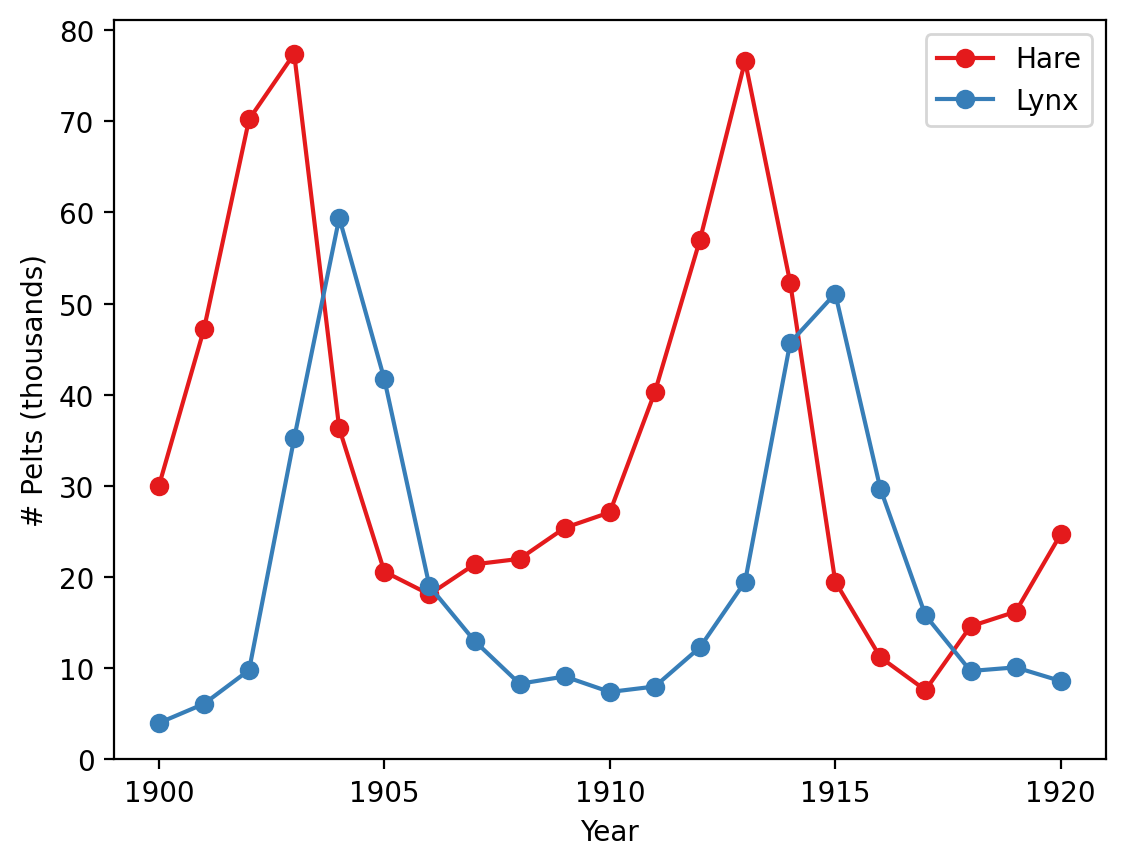

In [6]:
def plot_setup():
    plt.xlabel('Year')
    plt.ylabel('# Pelts (thousands)')
    plt.legend(['Hare', 'Lynx'])
    plt.ylim(0, None)
    plt.xticks([1900, 1905, 1910, 1915, 1920])

plt.plot(data['year'], data['hare'], '-o', color=red)
plt.plot(data['year'], data['lynx'], '-o', color=blue)
plot_setup()

We can see the cycles that we discussed in the predator-prey class.

## Predator-prey model

This is the same model we used earlier in the course.
I use [Numba]() JIT-compile the functions to improve running time, as we will run these functions many many times.

In [7]:
from numba import njit

@njit
def ode(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return [dx, dy]

@njit
def jac(t, xy, b, h, ϵ, d):
    x, y = xy
    return [
        [b - h * y, -h * x],
        [ϵ * h * y, ϵ * h * x - d]
    ]

def predator_prey_model(θ, times=data['year']):
    θ = np.maximum(θ, 0) # parameters cannot be negative
    sol = solve_ivp(ode, (times.min(), times.max()), θ[-2:], t_eval=times, args=θ[:-2])#, method='BDF', jac=jac,)
    assert sol.success, θ
    return np.array([sol.y[0], sol.y[1]])

Let's plot some guess for the model parameters and the data. I played a bit with the parameters to get something that looks close enough. You can play with them further.

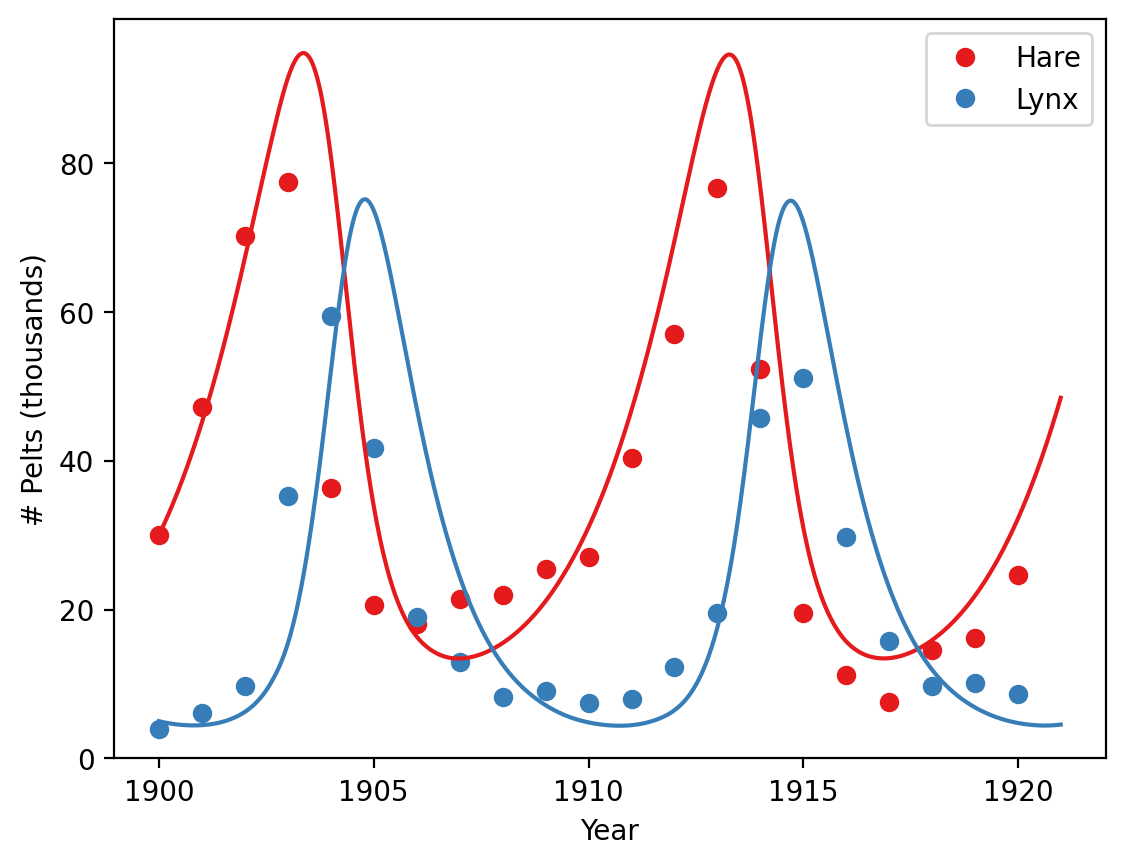

In [8]:
plt.plot(data['year'], data['hare'], 'o', color=red)
plt.plot(data['year'], data['lynx'], 'o', color=blue)

θ_guess = [0.5, 0.02, 1.2, 1, 30, 5]
t = np.arange(1900, 1921, 0.01)
x, y = predator_prey_model(θ_guess, t)
plt.plot(t, x, color=red)
plt.plot(t, y, color=blue)
plot_setup()

## Maximum likelihood estimation

We first assume that observed values are normally distributed around the expected values, which are given by the solution of the ODE. 

Maximizing the log likelihood of the normal distribution reduces down to minimizing the sum of residual squares, so we define a function that, given parameters $\theta$ and data $XY$ returns the residuals, and apply `least_squares` to minimize this function.

In [9]:
def residuals(θ, XY):
    xy = predator_prey_model(θ)
    resid = xy - XY
    return resid.flatten()

In [44]:
%%time
mle_result = scipy.optimize.least_squares(residuals, θ_guess, args=(XY,))
assert mle_result.success, mle_result.message
θ_mle = mle_result.x
print('loss={:.2f}, b={:.2f}, h={:.2f}, ϵ={:.2f}, d={:.2f}, x0={:.2f}, y0={:.2f}'.format(mle_result.cost, *θ_mle))

loss=299.23, b=0.48, h=0.02, ϵ=1.11, d=0.93, x0=34.93, y0=3.91
CPU times: user 3.1 s, sys: 44 ms, total: 3.14 s
Wall time: 3.19 s


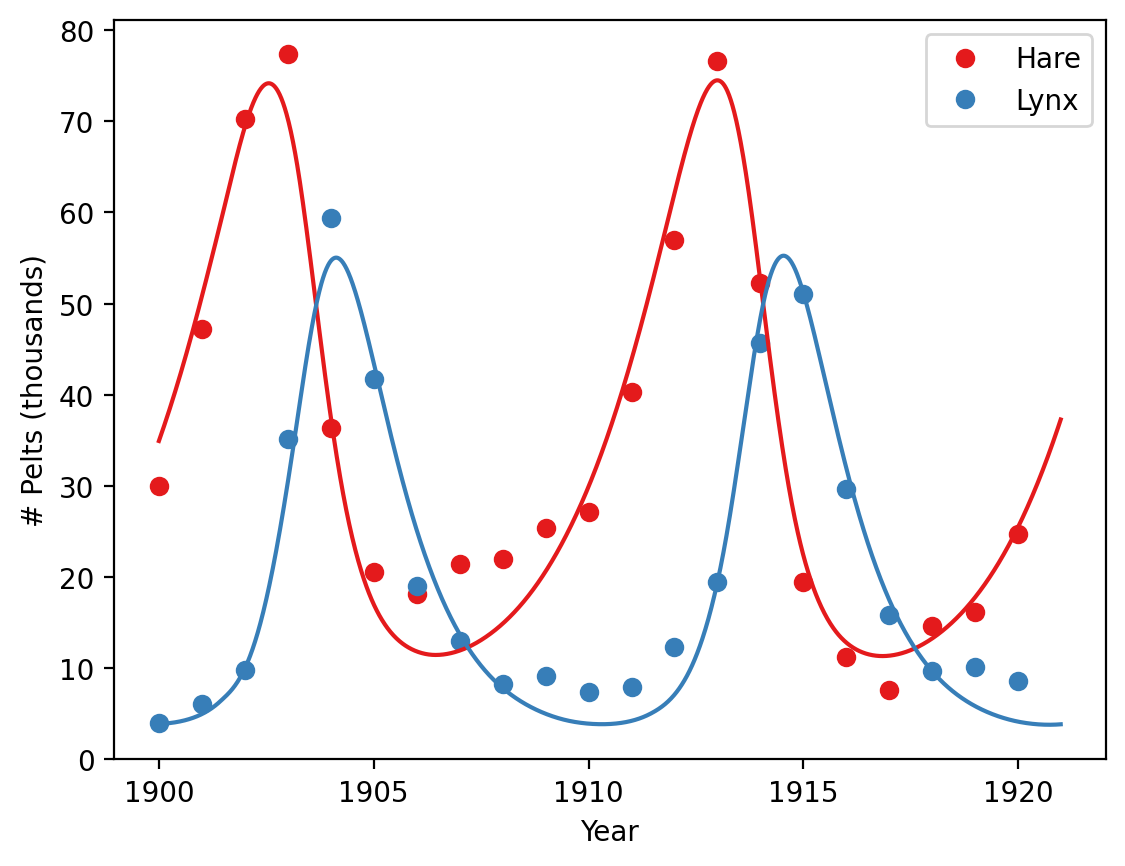

In [13]:
plt.plot(data['year'], data['hare'], 'o', color=red)
plt.plot(data['year'], data['lynx'], 'o', color=blue)

x, y = predator_prey_model(θ_mle, t)
plt.plot(t, x, color=red)
plt.plot(t, y, color=blue)
plot_setup();

This looks pretty good.

How sensitive are we to the initial guess we made? Pretty sensitive, unfortunately.
Here's a test - we draw random values in a wide range as guesses and check what the least squares algorithm gives us. You can see that the loss value (`cost`) is much higher than the one we found above.

In [43]:
θ_guesses = np.random.uniform([0,0,0,0,0,0], [2,1,3,2,80,80], size=(10, 6))
assert (θ_guesses > 0).all()
for θ_ in θ_guesses:
    mle_result = scipy.optimize.least_squares(residuals, θ_, args=(XY,))
    if not mle_result.success:
        print(mle_result.message)
    θ_mle_ = mle_result.x
    print('loss={:.2f}, b={:.2f}, h={:.2f}, ϵ={:.2f}, d={:.2f}, x0={:.2f}, y0={:.2f}'.format(mle_result.cost, *θ_mle_))

cost=19105.68, b=0.25, h=6.52, ϵ=-1.29, d=-0.02, x0=30.00, y0=20.17
cost=7359.81, b=-52.59, h=-50.91, ϵ=0.57, d=-38.94, x0=34.08, y0=20.17
cost=6692.09, b=0.06, h=0.00, ϵ=-4.85, d=-6.26, x0=48.58, y0=20.17
cost=6692.09, b=0.15, h=0.01, ϵ=-16.74, d=-3.87, x0=48.58, y0=20.17
cost=19105.68, b=-0.57, h=141.93, ϵ=-30.13, d=-1.45, x0=30.00, y0=20.17
cost=11630.10, b=-4.46, h=-1.01, ϵ=-1.04, d=-2.96, x0=34.08, y0=-12.04
cost=7359.81, b=-0.17, h=-0.19, ϵ=1.66, d=-0.86, x0=34.08, y0=20.17
cost=19105.68, b=-0.11, h=77.32, ϵ=-7.64, d=-3.47, x0=30.00, y0=20.17
cost=11630.10, b=-15.02, h=-1.30, ϵ=3.94, d=1.82, x0=34.08, y0=-12.95
cost=7359.81, b=-46.32, h=-15.55, ϵ=-7.84, d=-1.08, x0=34.08, y0=20.17


## Bayesian inference

Next, we apply Bayesian inference to the problem using [PyMC](https://pymc.io).

In [14]:
import pymc as pm
import arviz as az

print('PyMC', pm.__version__, 'Arviz', az.__version__)

PyMC 5.0.2 Arviz 0.15.1


We need to wrap our ODE model function `predator_prey_model` to a [pytensor](http://pytensor.readthedocs.io) function, because pytensor is the computational backend of PyMC (since v5). This is easily done by the following cell, which just defines the input and output types of the model function: `dvector` and `dmatrix` are a vector and a matrix of doubles, respectively.

In [15]:
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def predator_prey_model_op(θ):
    return predator_prey_model(θ)

The priors are defined as truncated normal distributions around the MLE; the truncation at zero avoids negative values for the parameters.

We set the distribution of the observations as Poisson around the expected value, as this is more reasonable than assuming a normal distribution.

We then sample from the posterior. I used the `Slice` sampler, which does not require gradients of the log-likelihood with respect to the model parameters (we could [do it with gradients](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_with_manual_gradients.html), but it will complicate the source code). Each chain took me about 15 mins to run on my laptop. You can [try another sampler if you want](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html#pymc-model-specification-for-gradient-free-bayesian-inference).

In [16]:
with pm.Model() as model:   
    b_mle, h_mle, ϵ_mle, d_mle, x0_mle, y0_mle = θ_mle
    b = pm.TruncatedNormal("b", mu=b_mle, sigma=0.1, lower=0, initval=b_mle)
    h = pm.TruncatedNormal("h", mu=h_mle, sigma=0.01, lower=0, initval=h_mle)
    ϵ = pm.TruncatedNormal("ϵ", mu=ϵ_mle, sigma=0.1, lower=0, initval=ϵ_mle)
    d = pm.TruncatedNormal("d", mu=d_mle, sigma=0.01, lower=0, initval=d_mle)
    x0 = pm.TruncatedNormal("x0", mu=x0_mle, sigma=1, lower=0, initval=x0_mle)
    y0 = pm.TruncatedNormal("y0", mu=y0_mle, sigma=1, lower=0, initval=y0_mle)

    ode_solution = predator_prey_model_op(pm.math.stack([b, h, ϵ, d, x0, y0]))
    XY_obs = pm.Poisson("XY_obs", mu=ode_solution, observed=XY)

In [46]:
with model:
    idata = pm.sample(step=[pm.Slice()], draws=2000, cores=1)
az.summary(idata)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [b]
>Slice: [h]
>Slice: [ϵ]
>Slice: [d]
>Slice: [x0]
>Slice: [y0]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 932 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b    0.549  0.013   0.524    0.571      0.000    0.000     827.0    1402.0   
h    0.027  0.001   0.025    0.029      0.000    0.000     257.0     494.0   
ϵ    0.847  0.048   0.760    0.938      0.003    0.002     288.0     730.0   
d    0.780  0.010   0.763    0.799      0.000    0.000    1433.0    1853.0   
x0  35.565  0.923  33.900   37.376      0.022    0.016    1693.0    2311.0   
y0   5.570  0.414   4.786    6.330      0.016    0.011     681.0    1045.0   

    r_hat  
b    1.00  
h    1.02  
ϵ    1.01  
d    1.00  
x0   1.00  
y0   1.01

The following saves and then loads the inference data to and from a file, so that we can continue working on it at a later time.

In [47]:
idata.to_netcdf("idata_hare_lynx.nc")

'idata_hare_lynx.nc'

In [18]:
idata = az.from_netcdf("idata_hare_lynx.nc")

Next we plot the traces and the marginal posteriors of the two chains to assess for convergence.

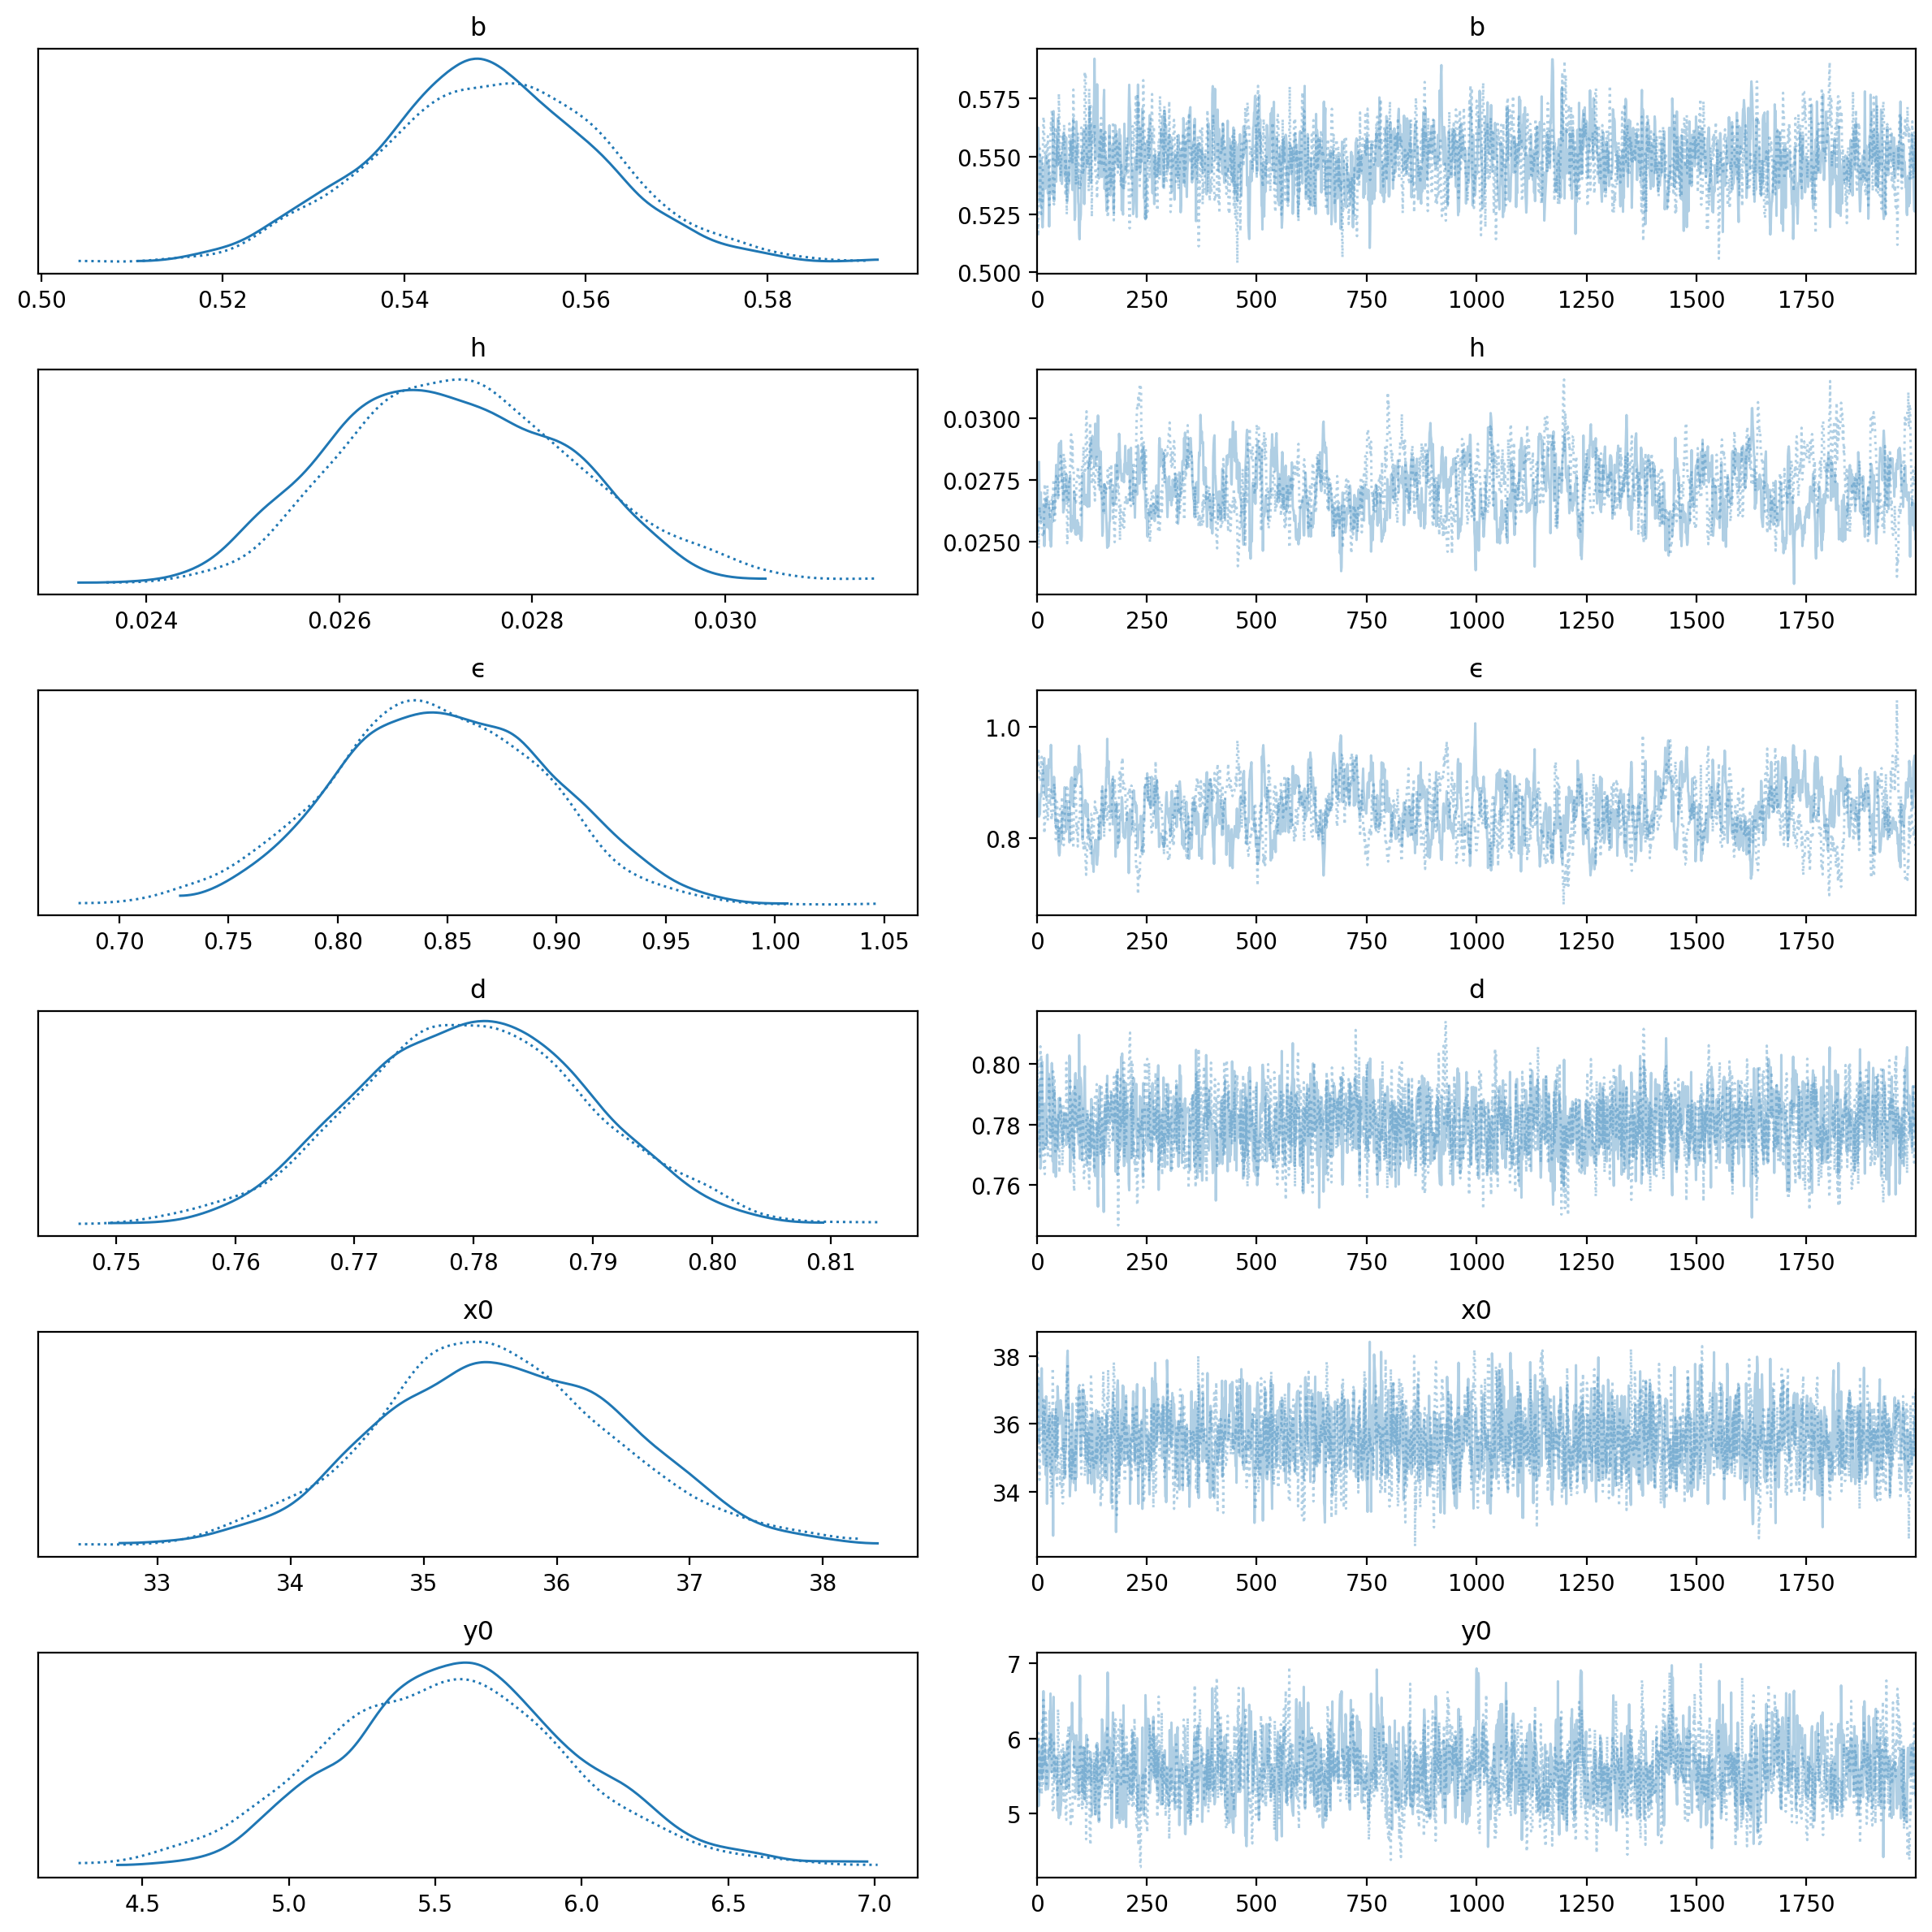

In [19]:
az.plot_trace(idata)
plt.tight_layout()

It seems that the chains have converged, so we can go ahead and look at the summary of the inference.

Not the `r_hat` and `ess` are measures for convergence and stability, respectively, read more at [Kruschke (2021) Bayesian Analysis Reporting Guidelines. _Nature Human Behaviour_](https://doi.org/10.1038/s41562-021-01177-7).

In [20]:
isummary = az.summary(idata, round_to=4)
isummary

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
b    0.5491  0.0126   0.5244   0.5713     0.0004   0.0003   826.9219   
h    0.0272  0.0012   0.0250   0.0294     0.0001   0.0001   257.2525   
ϵ    0.8471  0.0481   0.7600   0.9381     0.0028   0.0020   287.5587   
d    0.7800  0.0098   0.7627   0.7993     0.0003   0.0002  1433.0763   
x0  35.5646  0.9227  33.9000  37.3757     0.0225   0.0159  1692.5309   
y0   5.5695  0.4144   4.7856   6.3303     0.0159   0.0112   681.4913   

     ess_tail   r_hat  
b   1401.8144  1.0024  
h    493.7524  1.0152  
ϵ    729.8727  1.0125  
d   1853.0702  1.0002  
x0  2310.7919  1.0013  
y0  1044.9535  1.0087

Next, let's plot predictive plots to check if the estimated parameters can indeed reproduce the dynamics we observe in the data.

Here, I plot the data as circles, the dynamics using the MAP estimate as black lines, and the dynamics using 100 samples from the posterior as colored transparent lines.

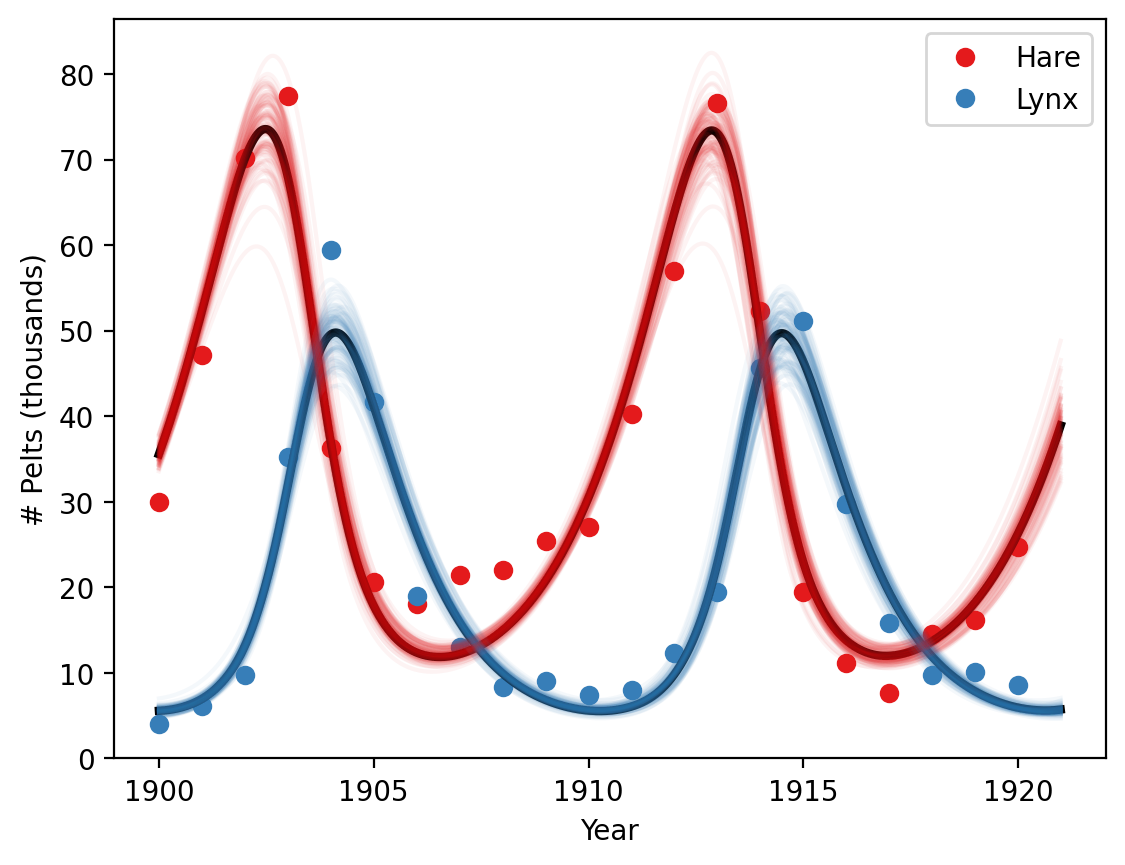

In [21]:
# data
plt.plot(data['year'], data['hare'], 'o', color=red)
plt.plot(data['year'], data['lynx'], 'o', color=blue)

# MAP prediction
θ_map = isummary['mean'].values
x, y = predator_prey_model(θ_map, t)
plt.plot(t, x, color='k', lw=3)
plt.plot(t, y, color='k', lw=3)

# posterior predictions 
posterior_samples = az.extract(idata, num_samples=100).to_dataframe()
for idx, row in posterior_samples.iterrows():
    θi = row[['b', 'h', 'ϵ', 'd', 'x0', 'y0']].values
    x, y = predator_prey_model(θi, t)
    plt.plot(t, x, color=red, alpha=0.05)
    plt.plot(t, y, color=blue, alpha=0.05)

plot_setup()

This seems pretty good, although some of the highest points in the data (both for hare and lynx) seem to be quite extreme compared to the posterior predictions.

Next let's look at the joint posterior distribution using a pair plot.

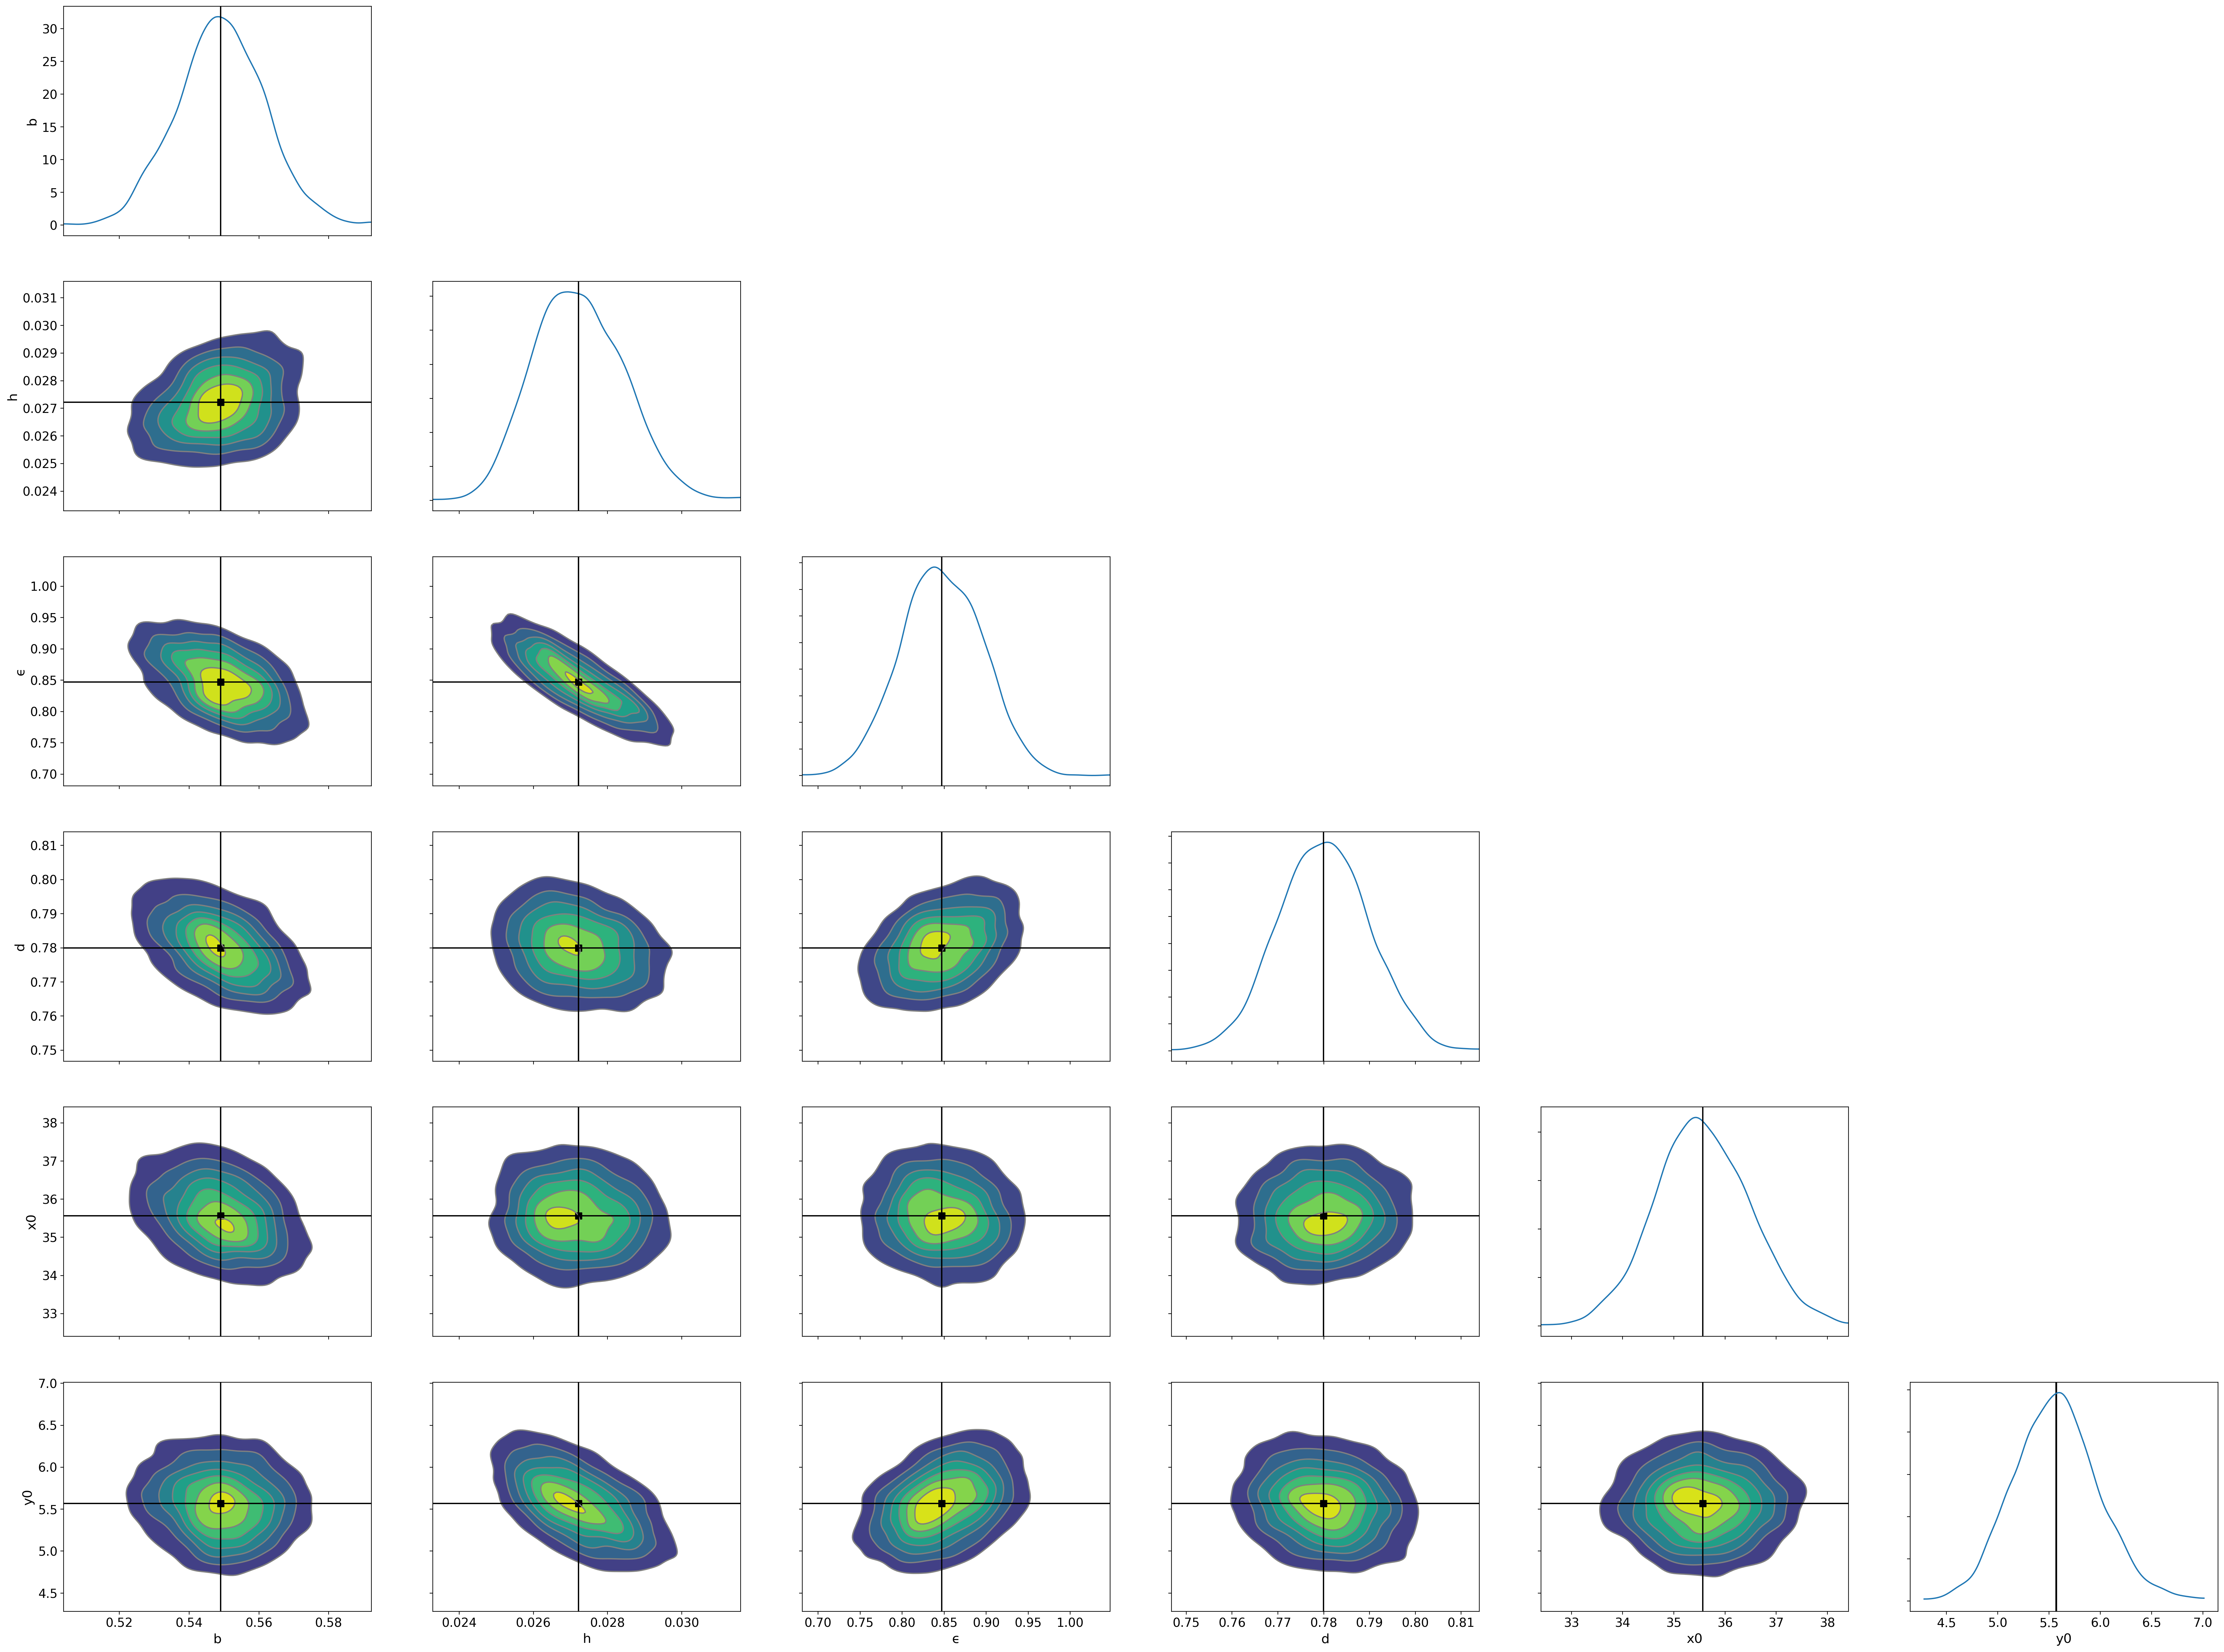

In [22]:
az.plot_pair(idata, kind='kde', marginals=True, point_estimate='mean');

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [Models in Population Biology](http://modelspopbiol.yoavram.com) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.

Here we see that the only parameters that seem strongly correlated are $h$ and $\epsilon$, which makes sense, as they appear as a product in the model. Perhaps we should redefine the model with a new parameter $\xi = \epsilon h$. Otherwise the distributions look nice and round.